In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
all_train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [201]:
all_train['Breed'] = all_train['Breed'].str.replace('Black/Tan', 'BlackTan')
all_train['Breed'] = all_train['Breed'].str.replace('/Unknown', ' Unknown')
all_train['Breed'] = all_train['Breed'].str.replace('St. Bernard Rough Coat', 'StBernard')
all_train['Breed'] = all_train['Breed'].str.replace('St. Bernard Smooth Coat', 'StBernard')
all_train['Breed'] = all_train['Breed'].str.replace('German Shorthair Pointer', 'Pointer')
all_train['Breed'] = all_train['Breed'].str.replace('German Wirehaired Pointer', 'Pointer')
all_train['Breed'] = all_train['Breed'].str.replace('Dachshund Longhair', 'Dachshund')
all_train['Breed'] = all_train['Breed'].str.replace('Dachshund Wirehair', 'Dachshund')
all_train['Breed'] = all_train['Breed'].str.replace('English Pointer', 'Pointer')
all_train['Breed'] = all_train['Breed'].str.replace('Chihuahua Shorthair', 'Chihuahua')
all_train['Breed'] = all_train['Breed'].str.replace('Chihuahua Longhair', 'Chihuahua')
all_train['Breed'] = all_train['Breed'].str.replace('Alaskan Husky', 'Husky')
all_train['Breed'] = all_train['Breed'].str.replace('Siberian Husky', 'Husky')

all_train['Breed'] = all_train['Breed'].str.replace(' ', '')
all_train['Breed'] = all_train['Breed'].str.replace('PitBull', ' PitBull ')
all_train['Breed'] = all_train['Breed'].str.replace('Rottweiler', ' Rottweiler ')
all_train['Breed'] = all_train['Breed'].str.replace('/', ' known ')
all_train['Breed'] = all_train['Breed'].str.replace('Mix', ' Mix ')
#all_train['Breed'] = all_train['Breed'].str.replace('Mix', '')
all_train['Breed'] = all_train['Breed'].str.replace('Unknown', '')
all_train['Breed'] = all_train['Breed'].str.replace('Australian', '')
all_train['Breed'] = all_train['Breed'].str.replace('American', '')
all_train['Breed'] = all_train['Breed'].str.replace('German', '')
all_train['Breed'] = all_train['Breed'].str.replace('YorkshireTerrier', ' Yorkshire ')


def replaceBreed (s):
    if re.sub(' ','', s).lower() in [u'rhodridgeback', u'rottweiler', u'pekingese', u'labradorretriever', u'known', u'blacktanhound', 
     u'yorkshire', u'doguedebordeaux', u'bullterrier', u'englishcockerspaniel', u'colliesmooth', u'chihuahua', 
     u'cairnterrier', u'weimaraner', u'dutchshepherd', u'englishbulldog', u'englishfoxhound', u'greatpyrenees', 
     u'chinesesharpei', u'cockerspaniel', u'dobermanpinsch', u'staffordshireterrier', u'alaskanmalamute', u'mix', 
     u'entlebucher', u'shihtzu', u'goldenretriever', u'bluetickhound', u'irishsetter', u'vizsla', 
     u'italiangreyhound', u'cattledog', u'shepherd', u'toypoodle', u'bassethound', u'englishsetter', 
     u'ratterrier', u'lhasaapso', u'chowchow', u'bichonfrise', u'redbonehound', u'westhighland', 
     u'dogoargentino', u'bulldog', u'stbernard', u'boxer', u'softcoatedwheatenterrier', u'englishshepherd', 
     u'queenslandheeler', u'manchesterterrier', u'anatolshepherd', u'bostonterrier', u'dalmatian', u'kelpie', 
     u'pbgv', u'bloodhound', u'pug', u'plotthound', u'collierough', u'staffordshire', u'englishspringerspaniel', 
     u'dachshund', u'englishcoonhound', u'pitbull', u'husky', u'blackmouthcur',u'devonrex', 
     u'mainecoon', u'persian', u'japanesebobtail', u'bombay', u'javanese', u'bengal', u'mix',
     u'cymric', u'cornishrex', u'balinese', u'domesticshorthair', u'domesticmediumhair', u'turkishvan', 
    u'snowshoe', u'domesticlonghair', u'shorthair', u'known', u'angora', u'exoticshorthair', u'tonkinese', 
    u'manx', u'havanabrown', u'britishshorthair', u'burmese', u'himalayan', u'russianblue']:
        return s
    else:
        return 'others'
    
all_train['Breed'] = all_train['Breed'].map(replaceBreed)


In [266]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
dayOfWeek_alt={0:'Monday', 1:'TuesFri', 2:'TuesFri', 3:'TuesFri', 4:'TuesFri', 5:'SatSun', 6:'SatSun'}
MonthName={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep',10:'Oct',11:'Nov',12:'Dec'} 
MonthName_alt={1:'JanFeb', 2:'JanFeb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul',
               8:'Aug', 9:'SepNov',10:'SepNov',11:'SepNov',12:'Dec'}
timeOfDay = {5: 'Morning', 6: 'Morning', 7: 'Morning', 8: 'Morning', 9: 'Morning', 10: 'Morning', 11: 'Afternoon',
        12: 'Afternoon', 13: 'Afternoon', 14: 'Afternoon', 15: 'Afternoon', 16: 'Night', 17: 'Night', 18: 'Night',
        19: 'Night', 20: 'Night', 21: 'Night', 22: 'Night', 23: 'Night', 0: 'Midnight',}

def RecodeAges(s):
    more3_yr = ['13year','14year','15year','16year','17year','18year','19year','20year','3year','4year','5year','6year','7year','8year','9year','10year','11year','12year']
    lessone_yr = ['3month','4month','5month','6month','7month','8month','9month','10month','11month','0year']
    lessone_wk = ['1day','2day','3day','4day','5day','6day']
    lessone_mo = ['1week','1week','2week','3week','4week']
    oneortwo_mo = ['1month','5week','2month']
    oneortwo_yr = ['1year','2year']
    
    if isinstance(s, str):
        age = re.sub('[s, ]','', s)
    else:
        return 'UnknownAge'
    
    if age in more3_yr:
        return 'More than 3 years'
    elif age in lessone_yr:
        return 'Less than one year'
    elif age in lessone_mo:
        return 'Less than one month'
    elif age in oneortwo_mo:
        return 'One to two months'
    elif age in oneortwo_yr:
        return 'One to two years'
    else:
        return 'Less than one week'

def process_data(df):
    df.ix[pd.isnull(df['Name']), 'Named'] = 'Unnamed'
    df.ix[pd.isnull(df['Named']), 'Named'] = 'Named'
    
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['weekday'] = df['DateTime'].dt.dayofweek.map(dayOfWeek_alt)
    df['month'] = df['DateTime'].dt.month.map(MonthName_alt)
    df['hour'] = df['DateTime'].dt.hour
    df['ageGroups'] = df['AgeuponOutcome'].map(RecodeAges)

    
    df['corp'] = df.apply(lambda x: ' '.join((x.Color, x.Breed, 
                                                       x.SexuponOutcome, x.Named, 
                                                       x.weekday, x.month)), axis=1)

    return df

all_train = process_data(all_train)



cv = CountVectorizer(min_df=0.05)
train_corpus = cv.fit_transform(all_train.corp)

def add_other_features(corpus, df, training=True):
    dense_corpus = pd.DataFrame(corpus.toarray(), columns = cv.get_feature_names())

    add = pd.concat([(df.AnimalType == 'Dog').astype(int), 
                     pd.get_dummies(df.hour),
                    pd.get_dummies(df.ageGroups)], axis=1)
    
    if training:
        add = pd.concat([add, df.OutcomeType], axis=1)
    return pd.concat([dense_corpus, add], axis=1)

new_corp = add_other_features(train_corpus, all_train)

split = new_corp.shape[0] // 20
dev = new_corp.iloc[:split,:-1]
train = new_corp.iloc[split:,:-1]

dev_labels = new_corp.iloc[:split,-1]
train_labels = new_corp.iloc[split:,-1]



Logistic Regression Log Loss: 0.834
Logistic Regression Accuracy: 0.654


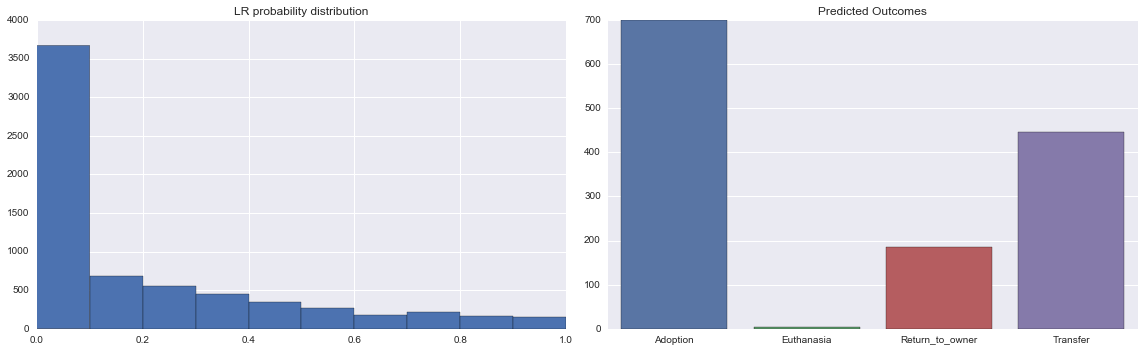

In [268]:
clf = LogisticRegression(penalty='l1', C=0.1)
clf.fit(train, train_labels)
probs = clf.predict_proba(dev)
preds = clf.predict(dev)
print 'Logistic Regression Log Loss: {:.3f}'.format(log_loss(dev_labels, probs))
print 'Logistic Regression Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))

feat_import = pd.DataFrame(clf.coef_, 
                           columns=train.columns, 
                           index=clf.classes_).T.sort_values('Adoption', ascending=False)

plt.figure(figsize=(16,5)) 
# plt.subplot(1,2,1)
# sns.barplot(, orient="h", palette='Blues_d')
# plt.title('Feature Weights')

plt.subplot(1,2,1)
plt.hist(probs.ravel(), range=[0,1])
plt.title('LR probability distribution')

plt.subplot(1,2,2)
sns.barplot(np.unique(preds, return_counts=True)[0], np.unique(preds, return_counts=True)[1])
plt.title('Predicted Outcomes')


# clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, criterion='entropy')
# clf.fit(train, train_labels)
# preds = clf.predict_proba(dev)
# print 'RF Log Loss: {:.3f}'.format(log_loss(dev_labels, preds, eps=0.1))
# print 'RF Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))

# plt.subplot(2,2,4)
# plt.hist(preds.ravel(), range=[0,1])
# plt.title('RF probability distribution')

plt.tight_layout()

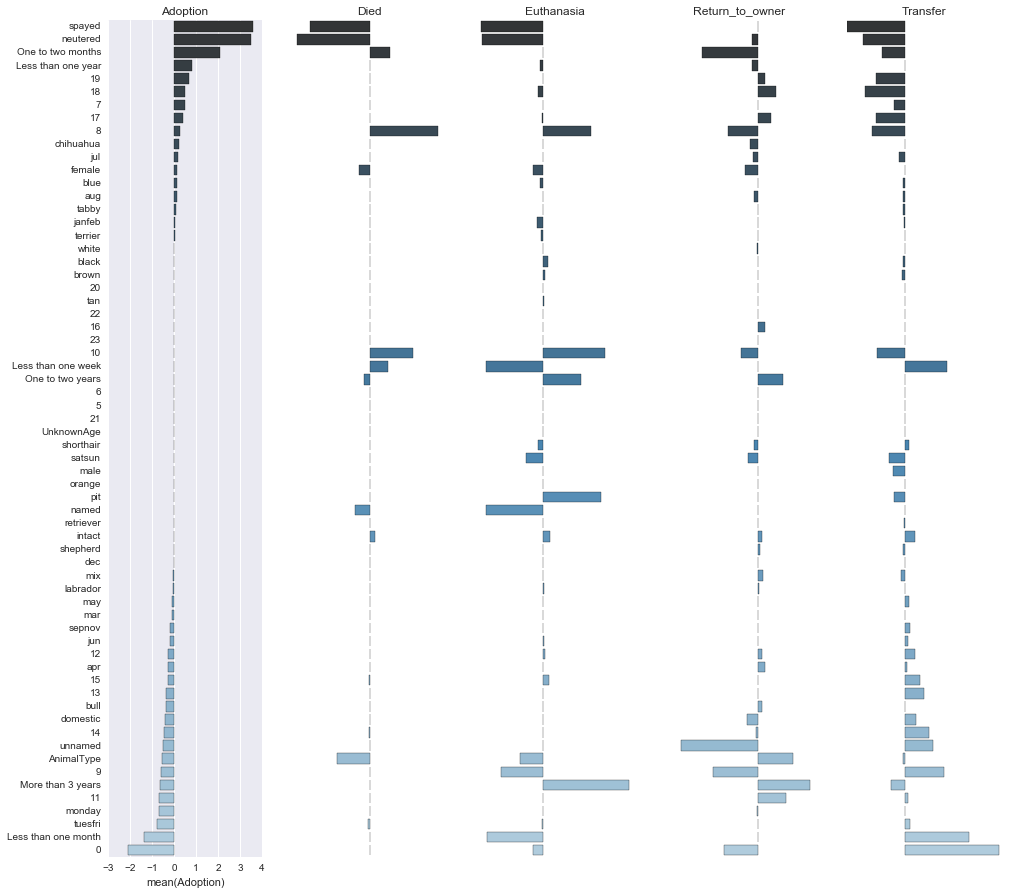

In [269]:
plt.figure(figsize=(16,15)) 

for i, j in enumerate(feat_import.columns):
    plt.subplot(1,5,i + 1)
    sns.barplot(x=feat_import.loc[:,j], y=feat_import.index, orient="h", palette='Blues_d')
    plt.title(j)
    if i > 0:
        plt.axis('off')

In [170]:
clf.fit(new_corp.iloc[:,:-1], new_corp.iloc[:,-1])

test = process_data(test)
test_corpus = cv.transform(test.corp)

new_test = add_other_features(test_corpus, test, training=False)

preds = clf.predict_proba(new_test)

for i, outcome in enumerate(clf.classes_):
    test[outcome] = preds[:,i]

In [172]:
submission = test[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']]
submission.to_csv('submission.csv', index=False)